# CNN Based Fault Diagnosis using Continuous Wavelet Transform (CWT)

This post is exactly similar to the [previous post](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/Deep_Learning_CWRU_Blog.ipynb). In that post we used raw time domain data as input to CNN for fault classification. But in this post we will first transform the time domain data to wavelet domain and use the wavelet domain image for fault diagnosis. We will observe that this simple transformation improves the accuracy.


In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
print(tf.__version__)

2.0.0


## Data
We have used CWRU data for this demonstration. It is a standard database used in condition monitoring applications. We have used the drive end data that are sampled at 48 kHz sampling frequency when load of 1 hp is applied on the shaft. Normal data collected with 1 hp load have also been used. There are a total of 10 classes. The classes are

* C1  : Ball defect (0.007 inch, load: 1 hp)
* C2  : Ball defect (0.014 inch, load: 1 hp)
* C3  : Ball defect (0.021 inch, load: 1 hp)
* C4  : Inner race fault (0.007 inch, load: 1 hp)
* C5  : Inner race fault (0.014 inch, load: 1 hp)
* C6  : Inner race fault (0.021 inch, load: 1 hp)
* C7  : Normal (load: 1 hp)
* C8  : Outer race fault (0.007 inch, load: 1 hp, data collected from 6 O'clock position)
* C9  : Outer race fault (0.014 inch, load: 1 hp, 6 O'clock)
* C10 : Outer race fault (0.021 inch, load: 1 hp, 6 O'clock)

From each category data are collected in segments of length 1024. Continuous wavelet transform (CWT) is then applied to this segment of data at 64 different scales. So output of wavelet transform is of size $(64 \times 1024)$. This is similar to the image that we see after wavelet transform. As input size to the model is $(32 \times 32)$, we resize the $(64 \times 1024)$ image into $(32 \times 32)$ using tensorflow. Details of the preprocessing step along with code can be found [here](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/CWRU_CNN_Wavelet_image_data_preparation_Git_Final.ipynb). Readers can directly download the processed data from the link mentioned below. There is no overlap between segments. For each category 460 such segments are taken. Total size of the data thus becomes (4600, 32, 32). Out of this 1300 segments are randomly chosen as test data and rest are used for training. 

[Download the data from here](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/data/CWRU_48k_load_1_CNN_wavelet_morlet_data.npz). Another convenient way is to [download the whole repository](https://codeload.github.com/biswajitsahoo1111/cbm_codes_open/legacy.zip/master) and run the downloaded notebooks.

[(Click here to see how the data have been preprocessed.)](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/CWRU_CNN_Wavelet_image_data_preparation_Git_Final.ipynb)

(**Note**: In the original data of CWRU, inner race fault of 0.014 inch with sampling frequency of 48 kHz and load of 1 hp is stored as a file named '175.mat'. Inside this file there are following sub fields:
            
            X217: [489125×2 double]
    X217_DE_time: [489125×1 double]
    X175_DE_time: [381890×1 double]
    X175_FE_time: [381890×1 double]
         X175RPM: 1772
         
The file 'X175_DE_time' has less data points. From it we can't extract 460 segments of length 1024 without overlap. So we have used 'X217_DE_time' instead as our 0.014 inch outer race fault data. From this file 460 segments can be extracted. In the 'numpy' file this data is used for 'IR_014' category. For all other categories respective drive end data are used.)

In [3]:
# Clone the repo and run current notebook.
file = np.load('./data/CWRU_48k_load_1_CNN_wavelet_morlet_data.npz')
print(file.files)

['data', 'labels']


In [4]:
data = file['data']
labels = file['labels']
print(data.shape, labels.shape)

(4600, 32, 32) (4600,)


In [5]:
print(data[0])
print(labels)

[[ 0.06489466  0.06258056  0.11481723 ...  0.11298084 -0.07618546
  -0.00962577]
 [ 0.01695936 -0.26479104  0.23692891 ... -0.01805164 -0.23221928
   0.17369527]
 [-0.09308606 -0.07591055  0.04793139 ...  0.1505585   0.0248714
  -0.0505239 ]
 ...
 [ 0.10248408 -0.27096152 -0.30217856 ... -0.04066667  0.27857864
   0.48639479]
 [ 0.13174711  0.10673141  0.03245776 ...  0.13669541  0.0687592
   0.06441689]
 [-0.00760916 -0.1538495  -0.30417514 ... -0.22986597 -0.20058736
  -0.12898165]]
['Ball_007' 'Ball_007' 'Ball_007' ... 'Normal' 'Normal' 'Normal']


In [6]:
category_labels = np.unique(labels)
print(category_labels)

['Ball_007' 'Ball_014' 'Ball_021' 'IR_007' 'IR_014' 'IR_021' 'Normal'
 'OR_007' 'OR_014' 'OR_021']


In [7]:
labels = pd.Categorical(labels, categories = category_labels).codes

## Train test split

In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 1300, random_state = 1928,
                                                                   stratify = labels)

In [9]:
# reshape data as input should be three dimensional to a CNN

train_data = train_data.reshape(3300,32,32,1)
test_data = test_data.reshape(1300,32,32,1)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape )

(3300, 32, 32, 1) (3300, 10) (1300, 32, 32, 1) (1300, 10)


## Model
We have used LeNet-5 model for classification. Details of model architecture is shown below. Any other architecture can also be used. 

In [10]:
# LeNet-5
LeNet_5 = Sequential([
    layers.Conv2D(6,5,activation= 'relu', input_shape = (32,32,1)),
    layers.MaxPool2D(2),
    layers.Conv2D(16,5,activation = 'relu'),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(120,activation = 'relu'),
    layers.Dense(84, activation = 'relu'),
    layers.Dense(10, activation = 'softmax')
])
LeNet_5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

Deep learning model weights are initialized randomly. Due to inherent non-deterministic nature of processing, we will get different answers if we run the same model twice. The answers will also vary from computer to computer depending on architecture. The answers will also vary depending on software version. In our experiment we have used `Tensorflow-2.0.0`. So we have run the model 10 times and final result is the average of all. In the process we have also saved the best model. 

In [11]:
res = np.empty(10)
res[:] = np.nan
for i in range(10):
    model = Sequential([
    layers.Conv2D(6,5,activation= 'relu', input_shape = (32,32,1)),
    layers.MaxPool2D(2),
    layers.Conv2D(16,5,activation = 'relu'),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(120,activation = 'relu'),
    layers.Dense(84, activation = 'relu'),
    layers.Dense(10, activation = 'softmax')
    ])
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics= ['accuracy'])
    history = model.fit(train_data, train_labels, epochs = 50, batch_size = 128, verbose = 0)    # Verbosity is set to zero
    res[i] = model.evaluate(test_data, test_labels, batch_size = 128, verbose = 0)[1]            # Verbosity is set to zero
    print('Loop iteration %d, Accuracy: %4.4f' % (i+1, res[i]))
    if res[i]>=np.max(res[:(i+1)]):
        best_model = model

Loop iteration 1, Accuracy: 0.9823
Loop iteration 2, Accuracy: 0.9815
Loop iteration 3, Accuracy: 0.9838
Loop iteration 4, Accuracy: 0.9823
Loop iteration 5, Accuracy: 0.9792
Loop iteration 6, Accuracy: 0.9831
Loop iteration 7, Accuracy: 0.9862
Loop iteration 8, Accuracy: 0.9754
Loop iteration 9, Accuracy: 0.9846
Loop iteration 10, Accuracy: 0.9831


In [12]:
print('Average accuracy:%4.4f'%(np.mean(res))) # After running the model 10 times
print('Standard deviation: %4.4f' % (np.std(res)))

Average accuracy:0.9822
Standard deviation: 0.0029


## Evaluating using best model

In [13]:
prediction = best_model.predict(test_data)
prediction_labels = list([])
for each_prediction in prediction:
    prediction_labels.append(list(each_prediction).index(max(each_prediction)))

In [14]:
from sklearn.metrics import confusion_matrix
true_labels = np.argmax(test_labels, axis = 1)
matrix = confusion_matrix(true_labels, prediction_labels)

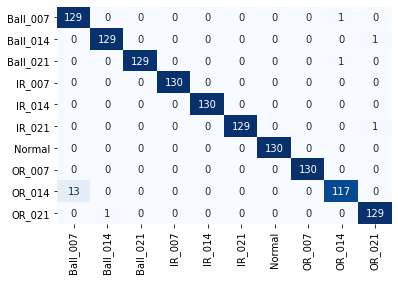

In [15]:
import seaborn as sns
matrix = pd.DataFrame(matrix)
plt.figure()
sns.heatmap(matrix, annot= True, fmt = "d",
           xticklabels = category_labels,
           yticklabels = category_labels, cmap = "Blues", cbar = False)
plt.xticks(rotation = 90)
plt.show()

Observe that by just transforming the data into frequency domain, we have achieved higher accuracy. Also note that we have not used any scaling to data. Usually in deep learning, input values are scaled to a range between (-1,1). We have not performed any such scaling here. In fact, in our case, scaling deteriorates performance slightly. Interested readers can apply scaling and see results themselves. The reason for this needs to be investigated further.

[For more results on both feature based methods and deep learning methods, visit my project page.](https://biswajitsahoo1111.github.io/cbm_codes_open/)

Last modified: 15 February, 2020